In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#<font color='orange'>Basics</font>

In [131]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [133]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [135]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

#Read Dataset

In [136]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [137]:
#@title Set seed
new_seed = True #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000_000) #to name the results files

    while seed_number <100000:
        seed_number = secrets.randbelow(1_000_000)
else:
    seed_number = 123123

main_seed = seed_number

print(seed_number)

956840


In [138]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=seed_number)

#Params

In [139]:
params_dict = ri.params_dict

In [140]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

In [141]:
train_tn = True
reuse_exec = True
eval_ri = True
use_test = False

In [158]:
n_iter = 50
size = 1000
p_value = 0.07
contamination_threshold = 0.12
year = 2000
tr_policy = 0.3
low_AR, high_AR = 0, 100
weights = [1,1]
criterias = [True, True]
tresh = (year - 2000)/10

In [159]:
# Define the file path
file_path = Path(os.path.join(ri_datasets_path,f'Data/TEST/TN-{year}-{tr_policy}-results.csv'))

# Check if the file exists
if os.path.exists(file_path):
    # Read the existing CSV file
    results_df = pd.read_csv(file_path)


In [160]:
results_df

,seed,model,size,p_value,contamination,AUC,KS,Kickout,AUK,unb_AUC,Best,Size_train_acp,Size_train_rej
0,472178,TN-EX,1000,0.07,0.12,0.663,0.262,0.108,0.066,0.648,50,8878,117077
1,472178,BM,-1,-1.00,-1.00,0.714,0.325,0.000,0.000,0.687,-1,8878,117077
2,472178,A-SC,-1,-1.00,-1.00,0.691,0.294,0.147,0.075,0.635,-1,8878,117077
3,472178,A-UW,-1,-1.00,-1.00,0.709,0.321,0.089,0.001,0.673,-1,8878,117077
4,472178,A-DW,-1,-1.00,-1.00,0.717,0.354,0.092,0.023,0.679,-1,8878,117077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,649846,A-DW,-1,-1.00,-1.00,0.664,0.284,0.095,0.010,0.694,-1,10062,115893
131,649846,A-FU,-1,-1.00,-1.00,0.642,0.253,-0.004,-0.007,0.709,-1,10062,115893
132,649846,E-C,-1,-1.00,-1.00,0.657,0.271,0.017,-0.012,0.712,-1,10062,115893
133,649846,PAR,-1,-1.00,-1.00,0.661,0.282,0.020,0.002,0.706,-1,10062,115893


In [161]:
results_df.Best.unique()

array([50, -1, 47, 40, 33, 13, 23, 28, 20, 16, 12, 46, 38])

In [162]:
grouped_df_mean = results_df.drop(['contamination','seed','size', 'p_value', 'Best'], axis=1).set_index(['model']).groupby(level=['model']).mean()
grouped_df_std = results_df.drop(['contamination','seed','size', 'p_value', 'Best'], axis=1).set_index(['model']).groupby(level=['model']).std()

grouped_df_mean.sort_values('AUK', ascending=False).round(3)
# grouped_df_mean.query('Kickout > 0.001').sort_values('AUK', ascending=False)

,AUC,KS,Kickout,AUK,unb_AUC,Size_train_acp,Size_train_rej
model,,,,,,,
TN-EX,0.683,0.291,0.075,0.059,0.666,7723.267,118231.733
LSP,0.697,0.320,0.081,0.049,0.662,7723.267,118231.733
A-SC,0.648,0.249,0.048,0.007,0.613,7723.267,118231.733
BM,0.697,0.314,0.000,0.000,0.678,7723.267,118231.733
PAR,0.705,0.322,0.019,-0.009,0.691,7723.267,118231.733
A-DW,0.680,0.296,0.037,-0.011,0.665,7723.267,118231.733
A-UW,0.686,0.304,0.026,-0.012,0.657,7723.267,118231.733
E-C,0.706,0.327,0.021,-0.016,0.699,7723.267,118231.733
A-FU,0.701,0.325,0.011,-0.017,0.694,7723.267,118231.733





#<font color='orange'>Helper Functions</font>


In [163]:
df = grouped_df_mean.copy().sort_values('AUC', ascending=False)

# Define a function to highlight the first and second best values in each column
def highlight_top_two(s):
    max_val = s.max()
    second_max_val = s.nlargest(2).iloc[-1]
    return ['background-color: blue' if v == max_val else 'background-color: lightgreen' if v == second_max_val else '' for v in s]

# Apply the function to each column in the rounded DataFrame using Styler
styled_df = df.style.apply(lambda s: highlight_top_two(s), subset=pd.IndexSlice[:, df.columns])

# Display the styled DataFrame
styled_df.format('{:.3f}')

,AUC,KS,Kickout,AUK,unb_AUC,Size_train_acp,Size_train_rej
model,,,,,,,
E-C,0.706,0.327,0.021,-0.016,0.699,7723.267,118231.733
PAR,0.705,0.322,0.019,-0.009,0.691,7723.267,118231.733
A-FU,0.701,0.325,0.011,-0.017,0.694,7723.267,118231.733
LSP,0.697,0.320,0.081,0.049,0.662,7723.267,118231.733
BM,0.697,0.314,0.000,0.000,0.678,7723.267,118231.733
A-UW,0.686,0.304,0.026,-0.012,0.657,7723.267,118231.733
TN-EX,0.683,0.291,0.075,0.059,0.666,7723.267,118231.733
A-DW,0.680,0.296,0.037,-0.011,0.665,7723.267,118231.733
A-SC,0.648,0.249,0.048,0.007,0.613,7723.267,118231.733


In [148]:
import dataframe_image as dfi

In [149]:


#dfi.export(styled_df, f'df_{(year-2000)/10}_styled-unb.png', dpi=300)

#---------------------------------

In [151]:
all_df = pd.DataFrame()
for thr in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]:
    # Define the file path
    file_path = Path(os.path.join(ri_datasets_path,f'Data/Test/TN-{0}-{thr}-results.csv'))

    # Check if the file exists
    if os.path.exists(file_path):
        # Read the existing CSV file
        results_df = pd.read_csv(file_path)
        results_df['threshold'] = thr
        all_df = pd.concat([all_df, results_df])

all_df

""


In [23]:
mean_hc = all_df.drop(['contamination','seed','size', 'p_value', 'Best', 'KS', 'Kickout'
              ], axis=1).set_index(['model', 'threshold']).groupby(level=['model', 'threshold']).mean().round(3)

In [48]:
mean_hc = mean_hc.query('threshold > 0.2')

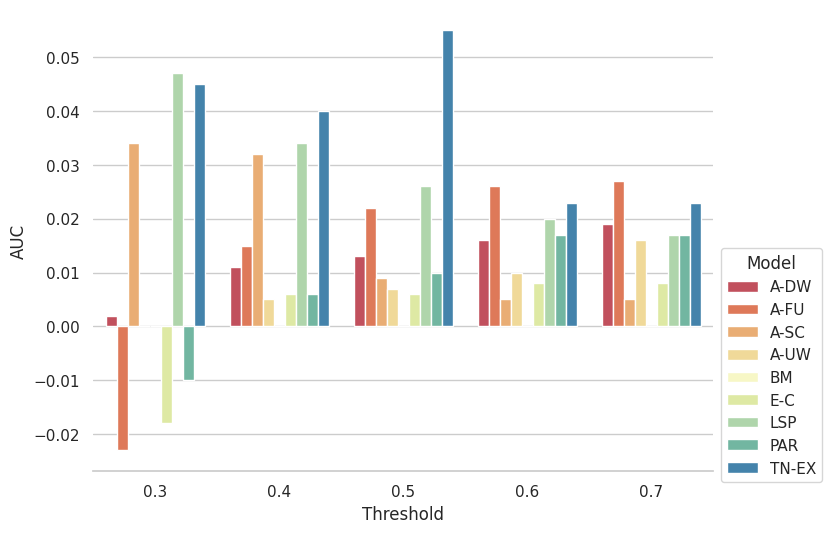

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar o tema
sns.set_theme(style="whitegrid")

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Desenhar o gráfico de barras
sns.barplot(
    data=mean_hc, x="threshold", y="AUK", hue="model",
    palette="Spectral", alpha=1, ax=ax
)

# Ajustar o limite do eixo y
# ax.set_ylim(0.55, None)  # None para 'auto'

# Ajustar rótulos dos eixos
ax.set_xlabel("Threshold")
ax.set_ylabel("AUC")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Ajustar o título da legenda
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5)).set_title("Model")


# Remover a espinha do lado esquerdo
sns.despine(left=True)

# Exibir o gráfico
plt.show()


In [46]:
temp_all = all_df.loc[all_df['model'] == 'TN-EX']
temp_all = temp_all.drop(['seed', 'contamination', 'size', 'model','Best', 'p_value'], axis=1, inplace=False)
corr = temp_all.corr().round(3)
corr

,AUC,KS,Kickout,AUK,threshold
AUC,1.000,0.735,-0.116,0.054,0.694
KS,0.735,1.000,-0.124,-0.384,0.246
Kickout,-0.116,-0.124,1.000,0.212,-0.255
AUK,0.054,-0.384,0.212,1.000,0.117
threshold,0.694,0.246,-0.255,0.117,1.000


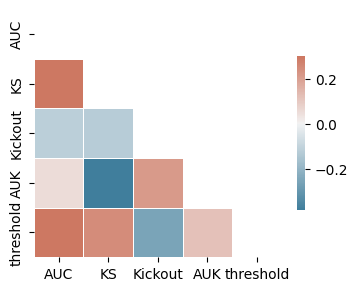

In [47]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('corr_HC.png', dpi=300)

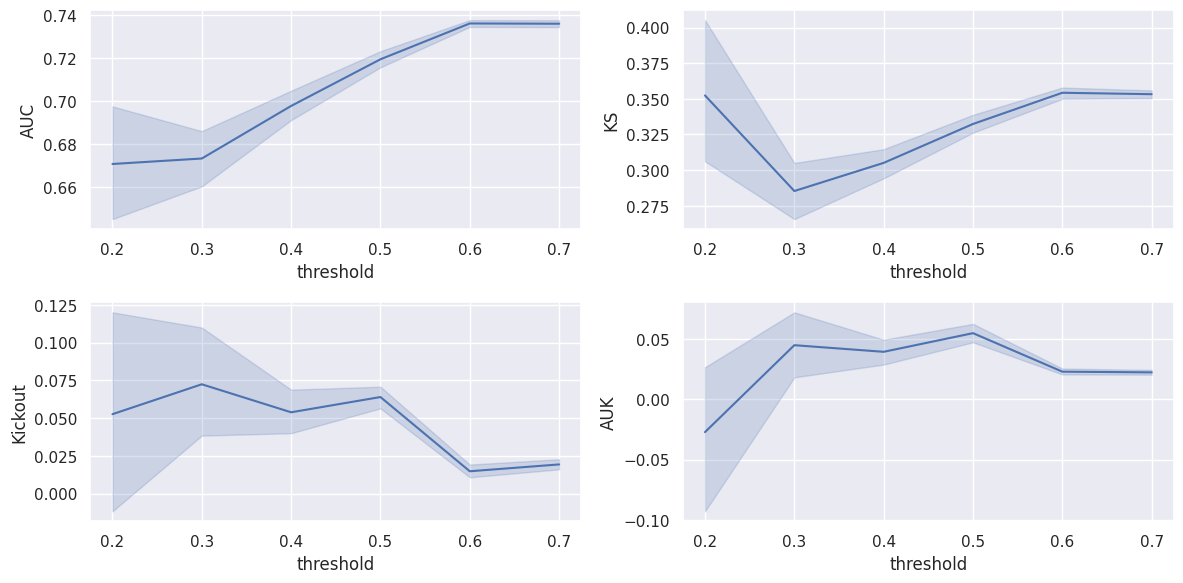

In [48]:
import seaborn as sns
sns.set_theme(style="darkgrid")
axs, figure = plt.subplots(2, 2, figsize=(12, 6))

# Plot the responses for different events and regions
sns.lineplot(data=temp_all, x="threshold", y="AUC", ax=figure[0, 0])
sns.lineplot(data=temp_all, x="threshold", y="KS", ax=figure[0, 1])
sns.lineplot(data=temp_all, x="threshold", y="Kickout", ax=figure[1, 0])
sns.lineplot(data=temp_all, x="threshold", y="AUK", ax=figure[1, 1])
plt.tight_layout()
plt.savefig('metrics_by_threshold.png', dpi=300)

In [78]:
df_train, df_val = train_test_split(
            df_train, test_size=0.2, random_state=seed_number)

In [79]:
df_train, policy_model = ri.fit_policy(df_train)

ok


In [80]:
X_train, y_train = df_train, df_train["TARGET"]
X_val, y_val = df_val, df_val["TARGET"]
X_test, y_test = df_test, df_test["TARGET"]

In [102]:
tresh = 0.7

In [103]:
X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model, threshold=tresh)
X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model, threshold=tresh)
X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model, threshold=tresh)

In [104]:
tr_dict[tresh] = X_train_acp.shape[0]/X_train_rej.shape[0]

In [105]:
tr_dict

{0.2: 0.013086352229586255,
 0.3: 0.07586719397299121,
 0.4: 0.3996244110587608,
 0.5: 1.3744485917882592,
 0.6: 5.477167540882443,
 0.7: 33.803813208068526}

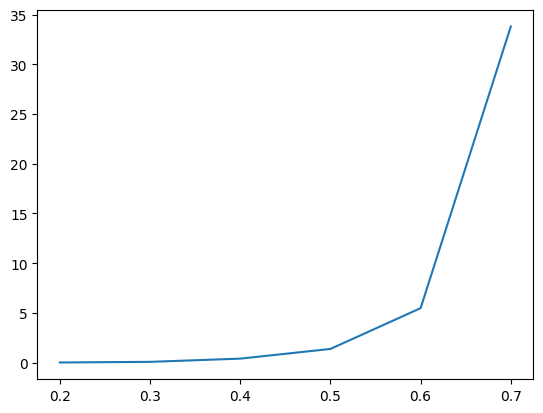

In [109]:
plt.plot(tr_dict.keys(), tr_dict.values())

In [85]:
tr_dict = {}

In [71]:
if use_test:
    X_eval = X_test_acp.copy()
    y_eval = y_test_acp.copy()
    R_eval = X_test_rej.copy()
else:
    X_eval = X_val_acp.copy()
    y_eval = y_val_acp.copy()
    R_eval = X_val_rej.copy()

In [72]:
dex.get_shapes(X_train, X_train_acp, X_train_rej, X_test, X_test_acp, X_test_rej, X_val, X_val_acp, X_val_rej)

df_train : (125955, 122)
X_train_acp : (33722, 15)
X_train_rej : (92233, 15)
df_test : (49202, 122)
X_test_acp : (13544, 15)
X_test_rej : (35658, 15)
df_val : (39362, 122)
X_val_acp : (10601, 15)
X_val_rej : (28761, 15)


In [73]:
models_dict = {}

filepath_models = Path(os.path.join(ri_datasets_path,f'HC/Models/RI/models-{seed_number}.joblib'))
if filepath_models.exists():
    models_dict = joblib.load(filepath_models)
    print(f'Models loaded with shape: {len(models_dict.keys())}')
else:
    benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                LGBMClassifier(**params_dict['LightGBM_2']))
    benchmark.fit(X_train_acp, y_train_acp)

    models_dict['BM'] = benchmark

    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    models_dict.update(
        ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    
    filepath_models.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(models_dict, filepath_models)

In [74]:
filepath_ex = Path(os.path.join(ri_datasets_path,f'HC/Models/TN-{seed_number}/{size}-{p_value}-{contamination_threshold}.joblib'))
datapath_ex = Path(os.path.join(ri_datasets_path,f'HC/Data/TN-/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet'))
if filepath_ex.exists() and reuse_exec:
    models_ex = joblib.load(filepath_ex)
    print(f'TN loaded with shape: {len(models_ex.keys())}')
else:
    print(f'TN fitting started with seed {seed_number}')
    TNmodels, TNdata = ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
                            X_val_acp, y_val_acp, iterations=n_iter,p = 0.07, output=-1,return_all=True,
                            save_log=False, seed=seed_number, technique='extrapolation')
    print(f'TN fitted')
    filepath_ex.parent.mkdir(parents=True, exist_ok=True)
    datapath_ex.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(TNmodels, filepath_ex)

    #------------------------------------
    print(f'starting compactation of TN data')
    train_list = [pd.DataFrame({**item, 'group': i}) for i, item in enumerate(TNdata['X'])]
    last_df = TNdata['unl'][-1].copy()
    last_df.loc[:, 'group'] = -1

    df = pd.concat(train_list, axis=0, ignore_index=False)
    df = pd.concat([df, last_df])

    min_values = df.group.groupby(level=0).min()
    last_value = TNdata['y'][-1]

    result_df = pd.DataFrame({
        'first_it': min_values,
        'label': last_value
    }, index=min_values.index)
    result_df = result_df.sort_values(by=['first_it'], ascending=True)
    result_df.fillna(-1, inplace=True)
    result_df = result_df.astype(int)

    result_df.to_parquet(datapath_ex)
    print(f'data saved to {datapath_ex}')
    #------------------------------------
    models_ex = TNmodels

TN fitting started with seed 427567
TN fitted
starting compactation of TN data
data saved to ../data/riData/HC/Data/TN-/427567/1000-0.06-0.12.parquet


In [75]:
if train_tn:
    filepath_ex = Path(os.path.join(ri_datasets_path,f'Models/TN-{"HC"}/{seed_number}/{size}-{p_value}-{contamination_threshold}.joblib'))
    datapath_ex = Path(os.path.join(ri_datasets_path,f'Data/TN-{"HC"}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet'))
    # filepath_ls = Path(os.path.join(ri_datasets_path,f'TN+-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.joblib'))

    if filepath_ex.exists() and reuse_exec:
        models_ex = joblib.load(filepath_ex)
        print(f'TN loaded with shape: {len(models_ex.keys())}')

if eval_ri:
    df_RI = ri.get_metrics_RI(models_dict, X_eval, y_eval, X_unl=R_eval, acp_rate=0.5)
    df_AUK = ri.area_under_the_kick(models_dict, X_eval, y_eval, R_eval, low_AR, high_AR).mean()
    df_AUC = df_RI.loc['AUC']
    df_KS = df_RI.loc['KS']

    

    if train_tn:
        # Initialize a dictionary to hold all the basic metrics for EX
        df_TN = ri.get_metrics_RI(models_ex, X_eval, y_eval, X_unl=R_eval, acp_rate=0.5)
        df_auc_ex = df_TN.loc['AUC', :]
        df_ks_ex = df_TN.loc['KS', :]
        df_kick_ex = ri.area_under_the_kick(models_ex, X_eval, y_eval, R_eval, low_AR, high_AR)
        output_ex, best_values_ex = ri.evaluate_by_AUC_AUK(models_ex,  X_eval, y_eval, R_eval, weights, criterias, low_AR, high_AR)
        
        if use_test:
            file_path = Path(os.path.join(ri_datasets_path,f'Data/TEST/TN-{year}-results.csv'))
            file_path.parent.mkdir(parents=True, exist_ok=True)
        else:
            file_path = Path(os.path.join(ri_datasets_path,f'Data/VAL/TN-{year}-results.csv'))
            file_path.parent.mkdir(parents=True, exist_ok=True)


        # Define the new data to be added (example data)
        new_data = {
            "seed": seed_number,
            "model": "TN-EX",
            "size": size,
            "p_value": p_value,
            "contamination": contamination_threshold,
            "AUC": df_TN.loc['AUC', f'TN_{output_ex}'],
            "KS": df_TN.loc['KS', f'TN_{output_ex}'],
            "Kickout": df_TN.loc['Kickout', f'TN_{output_ex}'],
            "AUK": df_kick_ex.loc[:, f'TN_{output_ex}'].mean(),
            "Best": output_ex,
        }

        # Convert new data to a DataFrame
        new_df = pd.DataFrame([new_data]).round(3)
        
        for col in df_RI.columns:
            new_data = {
                    "seed": seed_number,
                    "model": col,
                    "size": -1,
                    "p_value": -1,
                    "contamination": -1,
                    "AUC": df_RI.loc['AUC', col],
                    "KS": df_RI.loc['KS', col],
                    "Kickout": df_RI.loc['Kickout', col],
                    "AUK": df_AUK.loc[col],
                    "Best": -1,
                }
            col_df = pd.DataFrame([new_data]).round(3)
            new_df = pd.concat([new_df, col_df], ignore_index=True)

        # Check if the file exists
        if os.path.exists(file_path):
            # Read the existing CSV file
            existing_df = pd.read_csv(file_path)
            # Append the new data to the existing data
            updated_df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            # If the file does not exist, the new data itself is the updated data
            updated_df = new_df

        # Save the updated DataFrame back to the CSV file
        updated_df.to_csv(file_path, index=False)


In [76]:
updated_df

,seed,model,size,p_value,contamination,AUC,KS,Kickout,AUK,Best
0,123123,TN-EX,1000,0.06,0.12,0.717,0.326,0.040,0.006,17
1,123123,TN-EX,1000,0.06,0.12,0.717,0.326,0.040,0.006,17
2,123123,BM,-1,-1.00,-1.00,0.727,0.355,0.000,0.000,-1
3,123123,A-SC,-1,-1.00,-1.00,0.721,0.340,0.022,0.017,-1
4,123123,A-UW,-1,-1.00,-1.00,0.725,0.338,-0.008,0.011,-1
5,123123,A-DW,-1,-1.00,-1.00,0.723,0.336,0.001,0.011,-1
6,123123,A-FU,-1,-1.00,-1.00,0.701,0.297,0.012,0.014,-1
7,123123,E-C,-1,-1.00,-1.00,0.724,0.350,0.010,-0.012,-1
8,123123,PAR,-1,-1.00,-1.00,0.720,0.328,0.013,-0.010,-1
9,123123,LSP,-1,-1.00,-1.00,0.723,0.336,0.039,0.061,-1


In [24]:
file_path

PosixPath('../data/riData/Data/VAL/TN-0-results.csv')

#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [32]:
N_splits=5
kf = KFold(n_splits=N_splits, random_state=main_seed, shuffle=True)   #80-20 split for train-test
hist_dict = {}
data_dict = {}
run = False or True

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    df_train, policy_model = ri.fit_policy(df_train)

    X_train, X_test, X_val = df_train, df_test, df_val
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model)
    X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model)
    X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model)
    
    data_dict[fold_number] = [X_train_acp, X_train_rej, y_train_acp, y_train_rej,
                               X_test_acp, X_test_rej, y_test_acp,
                               X_val_acp, X_val_rej, y_val_acp]
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    models_dict = {}

    filepath_models = Path(os.path.join(ri_datasets_path,f'HC/Models/RI/models-{seed_number}.joblib'))
    if filepath_models.exists():
        models_dict = joblib.load(filepath_models)
        print(f'Models loaded with shape: {len(models_dict.keys())}')
    else:
        benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                    LGBMClassifier(**params_dict['LightGBM_2']))
        benchmark.fit(X_train_acp, y_train_acp)

        
        models_dict['BM'] = benchmark

        models_dict.update(
            ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        # models_dict.update(
        #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
        # models_dict.update(
        #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
        # models_dict.update(
        #     ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        # models_dict.update(
        #     ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        # models_dict.update(
        #     ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        # models_dict.update(
        #     ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        
        filepath_models.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(models_dict, filepath_models)

    if run:
        filepath_ex = Path(os.path.join(ri_datasets_path,f'HC/Models/TN-{seed_number}/{size}-{p_value}-{contamination_threshold}.joblib'))
        datapath_ex = Path(os.path.join(ri_datasets_path,f'HC/Data/TN-/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet'))
        if filepath_ex.exists():
            models_ex = joblib.load(filepath_ex)
            print(f'TN loaded with shape: {len(models_ex.keys())}')
        else:
            print(f'TN fitting started with seed {seed_number}')
            TNmodels, TNdata = ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
                                    X_val_acp, y_val_acp, iterations=5,p = 0.07, output=-1,return_all=True,
                                    save_log=False, seed=seed_number, technique='extrapolation')
            print(f'TN fitted')
            filepath_ex.parent.mkdir(parents=True, exist_ok=True)
            datapath_ex.parent.mkdir(parents=True, exist_ok=True)
            joblib.dump(TNmodels, filepath_ex)

            #------------------------------------
            print(f'starting compactation of TN data')
            train_list = [pd.DataFrame({**item, 'group': i}) for i, item in enumerate(TNdata['X'])]
            last_df = TNdata['unl'][-1].copy()
            last_df.loc[:, 'group'] = -1

            df = pd.concat(train_list, axis=0, ignore_index=False)
            df = pd.concat([df, last_df])

            min_values = df.group.groupby(level=0).min()
            last_value = TNdata['y'][-1]

            result_df = pd.DataFrame({
                'first_it': min_values,
                'label': last_value
            }, index=min_values.index)
            result_df = result_df.sort_values(by=['first_it'], ascending=True)
            result_df.fillna(-1, inplace=True)
            result_df = result_df.astype(int)

            result_df.to_parquet(datapath_ex)
            print(f'data saved to {datapath_ex}')
            #------------------------------------
            models_ex = TNmodels
          
    hist_dict[fold_number] = models_dict
        # metrics_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    print(fold_number)
    break
    # break

ok
Models loaded with shape: 2
TN loaded with shape: 6
0


In [19]:
data_ex = pd.read_parquet(datapath_ex)

In [20]:
data_ex

,first_it,label
index,,
61619,-1,-1
212458,-1,-1
212446,-1,-1
212444,-1,-1
212439,-1,-1
...,...,...
101498,5,0
93751,5,0
93752,5,0


In [49]:
iteration = 5

parquet_df = pd.read_parquet(datapath_ex)

train_i = parquet_df.loc[(data_ex.first_it <= iteration) & (data_ex.first_it >=0) ,:]
rej_left = parquet_df.loc[(data_ex.first_it==-1) ,:]
first_added = X_train_rej.loc[X_train_rej.index.intersection(train_i.index),:]

not_added = parquet_df.loc[(data_ex.first_it==-1) ,:]
df_left = X_train_rej.loc[X_train_rej.index.intersection(not_added.index),:]
df_left = pd.concat([df_left, rej_left], axis=1)

df_i = pd.concat([X_train_acp, first_added], axis=0)
df_i = pd.concat([df_i, train_i], axis=1)

assert df_i.shape[0] == (X_train_acp.shape[0] + first_added.shape[0])

In [51]:
models_dict = joblib.load(filepath_models)

In [53]:
df_all = pd.concat([df_i, df_left], axis=0)
df_all

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,NAME_CONTRACT_TYPE,first_it,label
254305,446931.0,0.247925,0.262055,NaN,0.007114,-8005,-14682,202500.0,1,3.0,0,369000.0,N,Secondary / secondary special,Cash loans,0,0
224672,98910.0,0.606197,0.484055,0.798137,0.025164,-10768,-17898,126000.0,0,2.0,0,90000.0,Y,Higher education,Cash loans,0,0
251457,239850.0,NaN,0.645288,0.733815,0.019101,365243,-24992,112500.0,0,1.0,0,225000.0,N,Secondary / secondary special,Cash loans,0,0
102178,675000.0,0.415831,0.749988,0.363945,0.032561,-2274,-15709,225000.0,1,2.0,0,675000.0,Y,Secondary / secondary special,Revolving loans,0,0
292546,677664.0,0.800846,0.486972,0.367291,0.031329,365243,-21281,112500.0,0,2.0,0,585000.0,N,Secondary / secondary special,Cash loans,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96556,135000.0,0.282048,0.675561,NaN,0.014520,-3454,-13621,112500.0,0,2.0,0,135000.0,N,Secondary / secondary special,Cash loans,-1,-1
144769,1125000.0,NaN,0.453520,0.508287,0.015221,-3913,-21195,112500.0,0,2.0,0,1125000.0,N,Secondary / secondary special,Cash loans,-1,-1
181168,1104997.5,NaN,0.155582,0.694093,0.007274,-215,-22157,382500.0,0,2.0,0,990000.0,N,Secondary / secondary special,Cash loans,-1,-1
240672,450000.0,NaN,0.600910,0.556727,0.028663,-6562,-18667,126000.0,0,2.0,0,450000.0,N,Secondary / secondary special,Cash loans,-1,-1


In [54]:
X = df_all.loc[:, ~df_all.columns.isin(['first_it', 'label'])]
X_scaled_df = models_dict['BM'][:-2].transform(X)
X_scaled_df

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE
254305,-0.436093,-2.432057,-1.744147,6.388790e-16,-1.104535,-0.775026,0.585693,0.122592,1.042951,1.142187,-0.286395,-0.518854,0,0,0.056018
224672,-1.215227,0.279302,-0.487796,1.552482e+00,-0.150912,-0.790693,-0.107289,-0.505444,-0.485821,-0.020482,-0.286395,-1.198554,1,0,0.036039
251457,-0.899696,0.000000,0.424665,1.182336e+00,-0.471234,1.341420,-1.635901,-0.616274,-0.485821,-1.183151,-0.286395,-0.869667,0,0,0.056018
102178,0.074498,-1.161365,1.017185,-9.460806e-01,0.239888,-0.742529,0.364395,0.307309,1.042951,-0.020482,-0.286395,0.226623,1,1,0.056018
292546,0.080462,1.752384,-0.471289,-9.268273e-01,0.174799,1.341420,-0.836257,-0.616274,-0.485821,-0.020482,-0.286395,0.007365,0,0,0.056018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96556,-1.134430,-2.173817,0.595986,6.388790e-16,-0.713259,-0.749220,0.814317,-0.616274,-0.485821,-0.020482,-0.286395,-1.088925,0,0,0.056018
144769,1.081937,0.000000,-0.660599,-1.154644e-01,-0.676223,-0.751823,-0.817725,-0.616274,-0.485821,-0.020482,-0.286395,1.322913,0,0,0.056018
181168,1.037157,0.000000,-2.346704,9.537562e-01,-1.096081,-0.730854,-1.025017,1.600324,-0.485821,-0.020482,-0.286395,0.994026,0,0,0.056018
240672,-0.429222,0.000000,0.173518,1.632866e-01,0.033948,-0.766843,-0.272993,-0.505444,-0.485821,-0.020482,-0.286395,-0.321522,0,0,0.056018


In [55]:
df_scaled = pd.concat([X_scaled_df, df_all.loc[:, ['first_it', 'label']]], axis=1)
df_scaled


,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,first_it,label
254305,-0.436093,-2.432057,-1.744147,6.388790e-16,-1.104535,-0.775026,0.585693,0.122592,1.042951,1.142187,-0.286395,-0.518854,0,0,0.056018,0,0
224672,-1.215227,0.279302,-0.487796,1.552482e+00,-0.150912,-0.790693,-0.107289,-0.505444,-0.485821,-0.020482,-0.286395,-1.198554,1,0,0.036039,0,0
251457,-0.899696,0.000000,0.424665,1.182336e+00,-0.471234,1.341420,-1.635901,-0.616274,-0.485821,-1.183151,-0.286395,-0.869667,0,0,0.056018,0,0
102178,0.074498,-1.161365,1.017185,-9.460806e-01,0.239888,-0.742529,0.364395,0.307309,1.042951,-0.020482,-0.286395,0.226623,1,1,0.056018,0,0
292546,0.080462,1.752384,-0.471289,-9.268273e-01,0.174799,1.341420,-0.836257,-0.616274,-0.485821,-0.020482,-0.286395,0.007365,0,0,0.056018,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96556,-1.134430,-2.173817,0.595986,6.388790e-16,-0.713259,-0.749220,0.814317,-0.616274,-0.485821,-0.020482,-0.286395,-1.088925,0,0,0.056018,-1,-1
144769,1.081937,0.000000,-0.660599,-1.154644e-01,-0.676223,-0.751823,-0.817725,-0.616274,-0.485821,-0.020482,-0.286395,1.322913,0,0,0.056018,-1,-1
181168,1.037157,0.000000,-2.346704,9.537562e-01,-1.096081,-0.730854,-1.025017,1.600324,-0.485821,-0.020482,-0.286395,0.994026,0,0,0.056018,-1,-1
240672,-0.429222,0.000000,0.173518,1.632866e-01,0.033948,-0.766843,-0.272993,-0.505444,-0.485821,-0.020482,-0.286395,-0.321522,0,0,0.056018,-1,-1


In [56]:
pca = PCA(n_components=2, random_state = seed_number)  # Reduce to 2 dimensions for visualization
principalComponents = pca.fit_transform(X_scaled_df)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['Pc1', 'Pc2'], index=X_scaled_df.index)

# Add the group information back for plotting
finalDf = pd.concat([principalDf, df_all.loc[:, ['first_it', 'label']]], axis = 1)


In [57]:
finalDf.first_it.unique()

array([ 0,  2,  5,  3,  4,  1, -1])

In [58]:
import math

# Define N as the total number of groups you want to plot
N = 5 #finalDf['first_it'].max()  # Number of unique first_its

# Calculate the number of rows and columns needed for the grid
n_cols = 5  # You can adjust this to your preference
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# For each first_it, create a KDE plot
for i in range(0, 5):  # Loop through the number of unique first_its
    ax = axs[i]
    sns.kdeplot(
        x="Pc1", y="Pc2", 
        data=finalDf.query(f"first_it <= {i} and label != 9999"),
        cmap="flare", fill=True, ax=ax
    )
    # sns.kdeplot(
    #     x="Pc1", y="Pc2", 
    #     data=finalDf.query(f"first_it <= {i} and label == 1"),
    #     cmap="Blues", fill=True, ax=ax
    # )
    ax.set_title(f'Group {i}', fontsize=8)
    ax.set_ylim([-4, 5])
    ax.set_xlim([-4, 5])

# Turn off the axes for any remaining empty subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
plt.show()


In [19]:
ri.calculate_kickout_metric(hist_dict[0]['BM'], hist_dict[0]['A-SC'], X_val_acp, y_val_acp, X_val_rej)

(0.011793376610329817, 114, 8)

In [38]:
# main_seed = 9555
seed_number = main_seed

In [39]:
for fold_number in range(N_splits):
    print(seed_number+fold_number)

15444
15445
15446
15447
15448


In [15]:
# AR = 0.88
# metrics_dict = {}
# for fold_number in range(N_splits):
#     X_train_acp, X_train_rej, y_train_acp, y_train_rej, X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

#     seed_number = main_seed+fold_number
#     filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
#     datasets = joblib.load(filepath)


#     values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
#                             acp_rate=AR).loc[
#                                 ["Overall AUC", "Kickout"]].T.to_numpy()
#     weights = [1,10]
#     criterias = np.array([True, True])
#     t = top.Topsis(values, weights, criterias)
#     t.calc()
#     output = t.rank_to_best_similarity()[0] - 1
#     print(f'best iteration: {output}')
#     if output != 0:
#         hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
#     else:
#         hist_dict[fold_number]['TN'] = datasets['BM']
#     # break

In [ ]:
# hist_kick = []

# for i in range(1,97):
#     AR = i/100.
#     metrics_dict = {}
#     for fold_number in range(N_splits):
#         X_train_acp, X_train_rej, y_train_acp, y_train_rej, X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

#         seed_number = main_seed+fold_number
#         filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
#         datasets = joblib.load(filepath)

#         values = []

#         for it in list(datasets.keys()):
#             auc_value = roc_auc_score(y_val_acp, datasets[it].predict_proba(X_val_acp)[:,1])
#             kick_value = ri.calculate_kickout_metric(datasets['BM'], datasets[it], X_val_acp, y_val_acp, X_val_rej, acp_rate=AR)
#             it_values = [auc_value, kick_value]
#             values.append(it_values)

#         values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
#                                 acp_rate=AR).loc[
#                                     ["Overall AUC", "Kickout"]].T.to_numpy()
#         weights = [1,10]
#         criterias = np.array([True, True])
#         t = top.Topsis(values, weights, criterias)
#         t.calc()
#         output = t.rank_to_best_similarity()[0] - 1
#         # print(f'best iteration: {output}')
#         if output != 0:
#             hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
#         else:
#             hist_dict[fold_number]['TN'] = datasets['BM']

#         metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=AR)
#     # break
#     mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
#     hist_kick.append(mean_metrics.loc[['Kickout']])
#     print(mean_metrics.loc[['Kickout']])

#     # break

In [44]:
hist_kick = []

for i in range(40,45):
    AR = i/100.
    metrics_dict = {}
    for fold_number in range(N_splits):
        X_train_acp, X_train_rej, y_train_acp, y_train_rej, X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

        seed_number = main_seed+fold_number
        filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
        datasets = joblib.load(filepath)

        values = []

        for it in list(datasets.keys()):
            auc_value = roc_auc_score(y_val_acp, datasets[it].predict_proba(X_val_acp)[:,1])
            kick_value = ri.calculate_kickout_metric(datasets['BM'], datasets[it], X_val_acp, y_val_acp, X_val_rej, acp_rate=AR)[0]
            it_values = [auc_value, kick_value]
            values.append(it_values)

        values = np.array(values)
        weights = [1,10]
        criterias = np.array([True, True])
        t = top.Topsis(values, weights, criterias)
        t.calc()
        output = t.rank_to_best_similarity()[0] - 1
        # print(f'best iteration: {output}')
        if output != 0:
            hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
        else:
            hist_dict[fold_number]['TN'] = datasets['BM']

        metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej,
                                                    acp_rate=AR, threshold_type='none')
    # break
    mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
    hist_kick.append(mean_metrics.loc[['Kickout']])
    print(mean_metrics.loc[['Kickout']])

    # break

          BM      A-SC        TN
Kickout  0.0  0.469514  0.483039
          BM     A-SC        TN
Kickout  0.0  0.44731  0.484416
          BM      A-SC        TN
Kickout  0.0  0.460041  0.451653
          BM      A-SC       TN
Kickout  0.0  0.483524  0.49267
          BM      A-SC        TN
Kickout  0.0  0.523575  0.527736


In [45]:
mean_metrics

,BM,A-SC,TN
Overall AUC,0.720724,0.713130,0.705341
KS,0.332525,0.323574,0.310177
Approval Rate,0.937877,0.924922,0.929903
Kickout,0.000000,0.523575,0.527736
KG,0.000000,435.400000,766.400000
KB,0.000000,20.200000,28.600000


In [46]:
df_kick = pd.concat(hist_kick, axis=0)

In [47]:
for column_name in df_kick.columns:
    column_data = df_kick[column_name]
    print(f"Column Name: {column_name}")
    print("Column Data:")
    print(column_data)
    print("--------------")

Column Name: BM
Column Data:
Kickout    0.0
Kickout    0.0
Kickout    0.0
Kickout    0.0
Kickout    0.0
Name: BM, dtype: float64
--------------
Column Name: A-SC
Column Data:
Kickout    0.469514
Kickout    0.447310
Kickout    0.460041
Kickout    0.483524
Kickout    0.523575
Name: A-SC, dtype: float64
--------------
Column Name: TN
Column Data:
Kickout    0.483039
Kickout    0.484416
Kickout    0.451653
Kickout    0.492670
Kickout    0.527736
Name: TN, dtype: float64
--------------


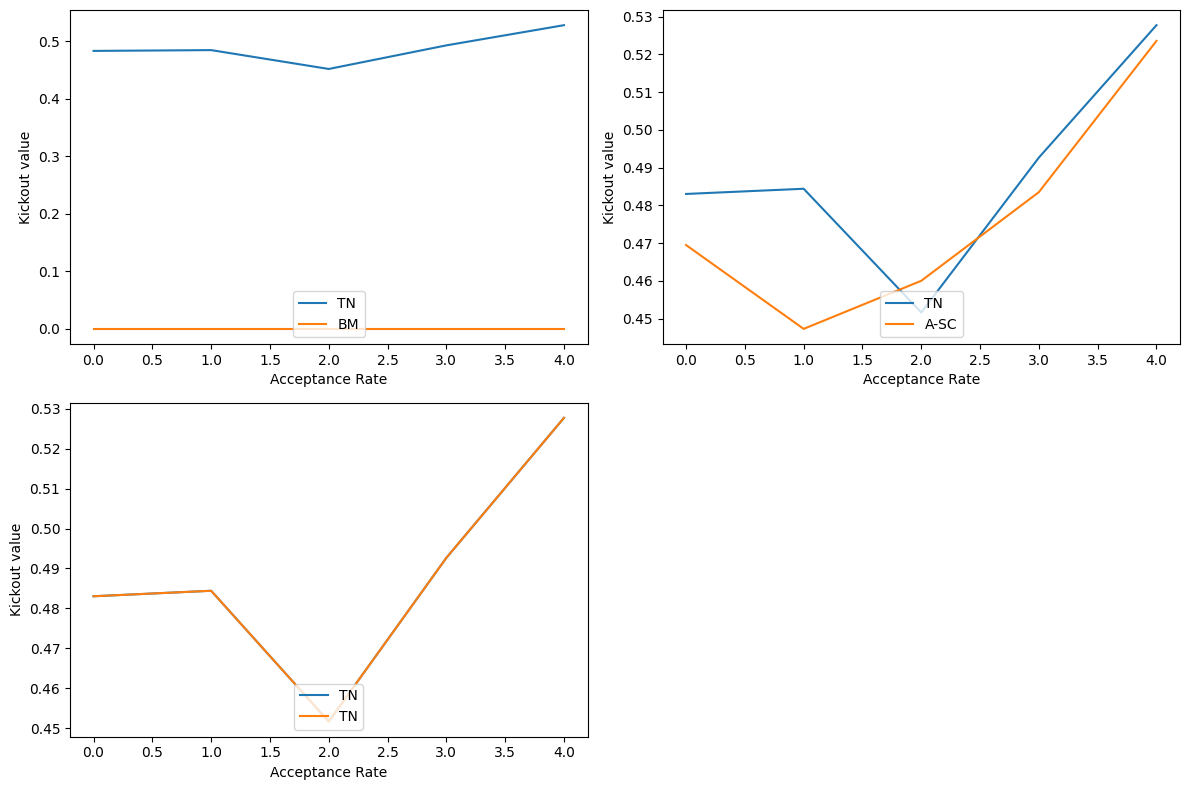

In [48]:
import math
import matplotlib.pyplot as plt

num_plots = len(df_kick.columns)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, column_name in enumerate(df_kick.columns):
    column_data = df_kick[column_name]
    row = i // num_cols
    col = i % num_cols

    axs[row, col].plot(df_kick['TN'].values, label='TN')
    axs[row, col].plot(column_data.values, label=column_name)
    axs[row, col].set_xlabel('Acceptance Rate')
    axs[row, col].set_ylabel('Kickout value')
    axs[row, col].legend(loc='lower center')

# Hide unused subplots
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    if num_rows == 1 and num_cols == 1:
        axs.axis('off')
    else:
        axs[row, col].axis('off')

plt.tight_layout()
plt.savefig(f'all_kick_by_AR_{main_seed}',  dpi=150)
plt.show()


ValueError: x and y can be no greater than 2D, but have shapes (96,) and (96, 1, 9)

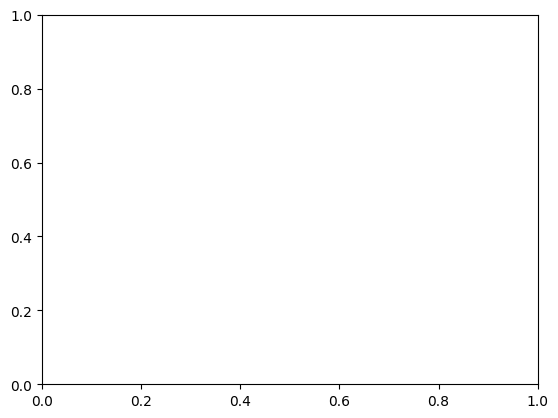

In [25]:
plt.plot(hist_kick)
plt.show()
# plt.savefig('kick_by_AR',  dpi=150)

In [24]:
# filepath = Path(os.path.join(ri_datasets_path,f'kickout-{main_seed}-ALL.joblib'))
# filepath.parent.mkdir(parents=True, exist_ok=True)
# joblib.dump(df_kick, filepath)

['../data/riData/kickout-5444-ALL.joblib']

In [ ]:
# mean_metrics = ri.get_metrics_RI(hist_dict[0], X_test_acp, 
#                                  y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.5)

In [ ]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=AR)
    # break
mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

    

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.723714,0.715438,0.720859,0.721782,0.691669,0.719875,0.717728,0.714254,0.707379
KS,0.332597,0.328778,0.332262,0.338015,0.289333,0.330676,0.324048,0.324543,0.308939
Balanced Accuracy,0.661032,0.661106,0.661436,0.661722,0.636495,0.656293,0.656869,0.653754,0.648553
Accuracy,0.702372,0.666749,0.641306,0.678005,0.663588,0.631125,0.664581,0.663273,0.635757
Precision,0.097385,0.091668,0.088799,0.094706,0.086454,0.087113,0.090580,0.089588,0.084562
Recall,0.615265,0.654826,0.683662,0.643566,0.606416,0.684054,0.648277,0.643232,0.662739
F1,0.167819,0.160636,0.156823,0.164165,0.150618,0.153912,0.158462,0.156822,0.149947
Approval Rate,0.937560,0.927719,0.931973,0.936380,0.914149,0.939397,0.937021,0.932209,0.923497
Kickout,0.000000,0.595869,0.299758,0.480291,0.207402,0.295369,0.390701,0.562368,0.639263
KG,0.000000,394.400000,108.600000,162.000000,229.200000,75.600000,82.000000,258.400000,553.400000


In [ ]:
metric = mean_metrics.loc[['Overall AUC', 'Kickout', 'Approval Rate'], 'TN']

In [ ]:
metric

Overall AUC      0.707379
Kickout          0.639263
Approval Rate    0.923497
Name: TN, dtype: float64

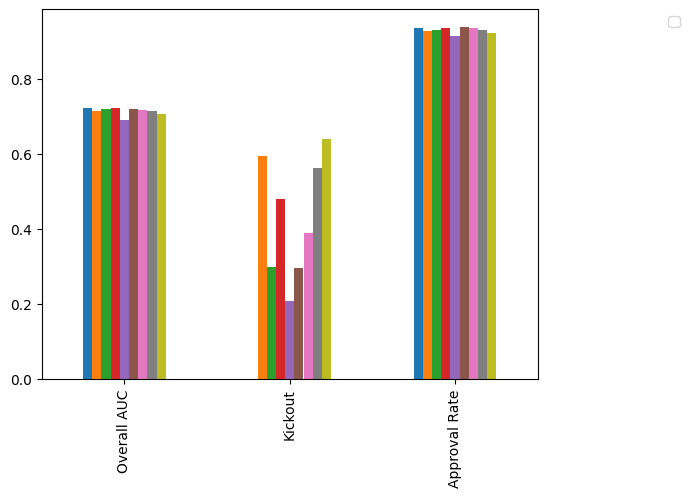

In [ ]:
metric.plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))
plt.show()

In [ ]:
# AR = 0.8

In [ ]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=AR)

In [ ]:
cols = ['Overall AUC','Kickout',]

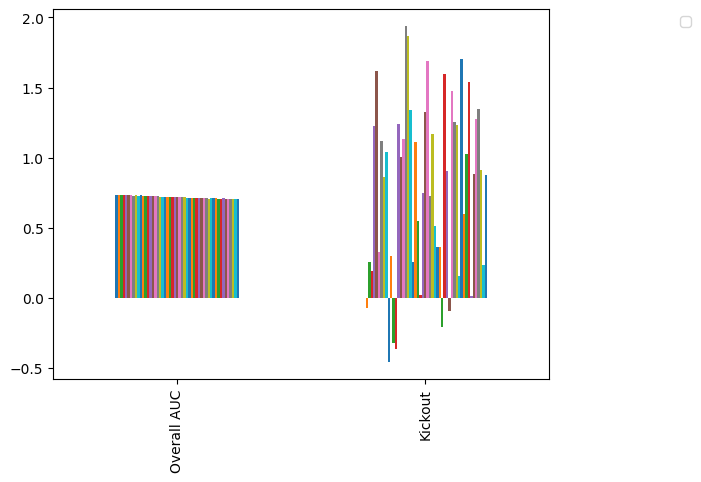

In [ ]:
metrics.loc[cols].plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

In [ ]:
metrics

,BM,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,...,TN_41,TN_42,TN_43,TN_44,TN_45,TN_46,TN_47,TN_48,TN_49,TN_50
Overall AUC,0.733256,0.734027,0.734435,0.735068,0.734668,0.734612,0.732012,0.730095,0.731365,0.730129,...,0.709029,0.708862,0.708267,0.708985,0.706606,0.706427,0.706937,0.707295,0.707632,0.705952
KS,0.352863,0.355920,0.350561,0.355742,0.365893,0.359213,0.357499,0.355781,0.355432,0.356794,...,0.314461,0.311651,0.309941,0.315502,0.305765,0.310062,0.307019,0.311385,0.320709,0.308299
Balanced Accuracy,0.674276,0.673098,0.668296,0.668849,0.672535,0.674106,0.674892,0.671259,0.674128,0.670338,...,0.649642,0.655215,0.651630,0.649908,0.647900,0.651324,0.648701,0.651631,0.654676,0.649261
Accuracy,0.670786,0.662310,0.717955,0.606859,0.640052,0.636817,0.652022,0.611453,0.653057,0.629634,...,0.679909,0.665610,0.637593,0.666710,0.649175,0.641993,0.671886,0.632611,0.649628,0.636817
Precision,0.092201,0.090743,0.098585,0.083476,0.087794,0.087749,0.089787,0.084409,0.089750,0.086135,...,0.087568,0.087037,0.082991,0.085923,0.083407,0.083391,0.086286,0.082476,0.084986,0.082393
Recall,0.678129,0.685007,0.613480,0.737276,0.708391,0.715268,0.700138,0.737276,0.697387,0.715268,...,0.616231,0.643741,0.667125,0.631362,0.646492,0.661623,0.623109,0.672627,0.660248,0.662999
F1,0.162331,0.160257,0.169872,0.149972,0.156226,0.156320,0.159162,0.151477,0.159034,0.153755,...,0.153346,0.153342,0.147618,0.151261,0.147752,0.148114,0.151581,0.146935,0.150588,0.146571
Approval Rate,0.950696,0.949984,0.947525,0.950954,0.944937,0.945066,0.947137,0.945455,0.946684,0.945843,...,0.926432,0.926302,0.923714,0.926626,0.924685,0.926561,0.922096,0.928243,0.927661,0.929149
Kickout,0.000000,-0.070845,0.254768,0.194823,1.226158,1.617166,0.328338,1.121253,0.859673,1.043597,...,0.596730,1.025886,1.542234,0.014986,0.884196,1.275204,1.346049,0.911444,0.231608,0.873297
KG,0.000000,13.000000,45.000000,56.000000,142.000000,162.000000,215.000000,253.000000,301.000000,359.000000,...,808.000000,821.000000,818.000000,823.000000,847.000000,867.000000,854.000000,842.000000,875.000000,849.000000


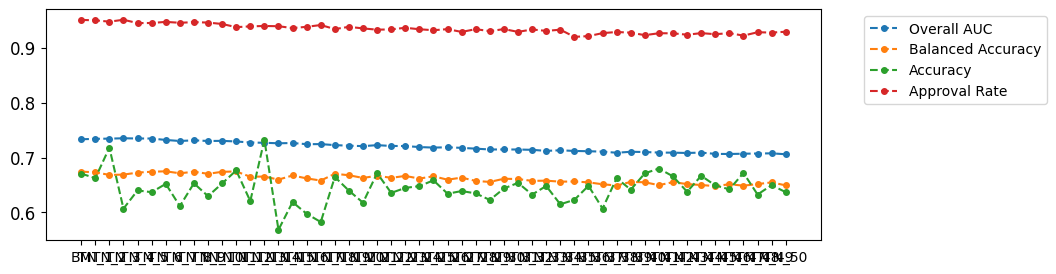

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

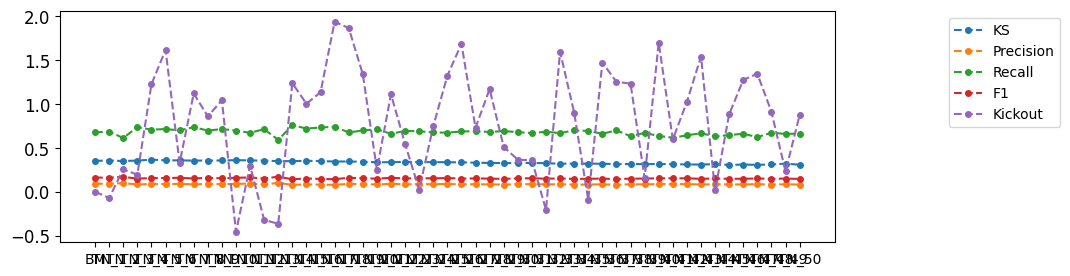

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()